2023-08-09 16:31:49.577129: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Trained dataset counts: Counter({'I': 5559, '4A': 5559, '3A': 5559, '5B': 5559, 'II': 5559, '4B': 5559, 'unk': 5559, '3B': 5559, '5C': 5559, '4C': 5559, 'VI': 5559})


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 11)                715       
                                                                 
Total params: 21,515
Trainable params: 21,515
Non-traina

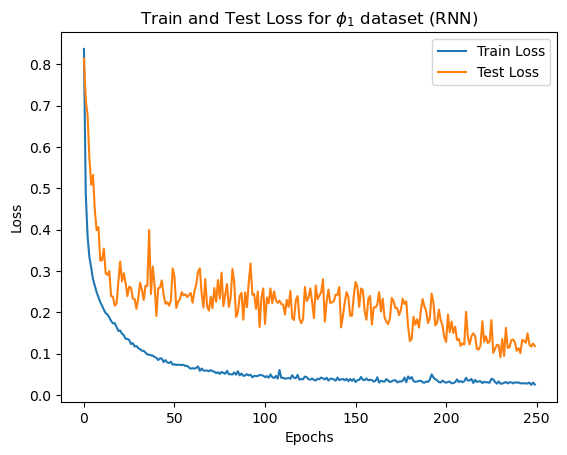

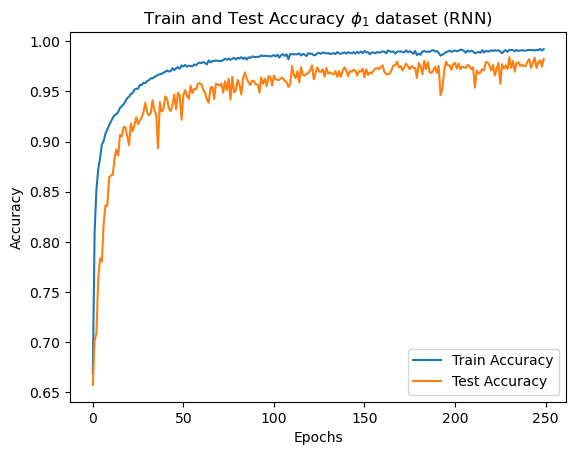

Test Accuracy:  0.9823232323232324
Mapping between react_type and one-hot encoding:
{'3A': 0, '3B': 1, '4A': 2, '4B': 3, '4C': 4, '5B': 5, '5C': 6, 'I': 7, 'II': 8, 'VI': 9, 'unk': 10}


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from brokenaxes import brokenaxes
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import random as rn
import tensorflow as tf

np.random.seed(1234)
rn.seed(1254)
tf.random.set_seed(1234)

import warnings
warnings.filterwarnings('ignore')

#data = pd.read_csv("c2h4_final_data_phi_1.csv")
data = pd.read_csv("c2h4_final_data_phi_1.csv")
#data = pd.read_csv("c2h4_scat_react_phi3.csv")
data = data[data['b'] <= 6.5]
data_process = data.copy()

# Data preprocessing
data_process.fillna(data_process.mode().iloc[0], inplace=True)  # Mode imputation
data_process["react_type"].replace({"1": "I", "2": "II"}, inplace=True)

# Train-test splitting
X_data = data_process[['Alpha', 'Beta', 'Gamma', 'b']]
y_data = data_process[['react_type']]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, stratify=y_data, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.values.ravel()

ros = RandomOverSampler(random_state=0)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
print('Trained dataset counts:', Counter(y_train_res))

# One-hot encode the target variables and get the mapping
num_classes = len(np.unique(y_train_res))
y_train_res_encoded = pd.get_dummies(y_train_res)
class_mapping = y_train_res_encoded.columns.tolist()

y_train_res = y_train_res_encoded.values
y_test_res_encoded = pd.get_dummies(y_test)
y_test_res = y_test_res_encoded.values

X_train_res = X_train_res.reshape(-1, 4, 1)
X_test = X_test.reshape(-1, 4, 1)

model = Sequential()
model.add(SimpleRNN(64, input_shape=(4, 1), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(Adam(lr=0.0001), "categorical_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(X_train_res, y_train_res, epochs=250, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test_res))

predictions = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(np.argmax(y_test_res, axis=1), predictions)

# Plotting train and test loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title(r'Train and Test Loss for $\phi_1$ dataset (RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("RNN_mult_class_phi1_loss")
plt.show()

# Plotting train and test accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train and Test Accuracy $\phi_1$ dataset (RNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("RNN_mult_class_phi1_train_test_accuracy")
plt.show()

print("Test Accuracy: ", accuracy)

# Mapping between react_type and one-hot encoding
react_type_mapping = {}
for i, react_type in enumerate(class_mapping):
    react_type_mapping[react_type] = i

print("Mapping between react_type and one-hot encoding:")
print(react_type_mapping)


In [2]:
predictions = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(np.argmax(y_test_res, axis=1), predictions)
precision = precision_score(np.argmax(y_test_res, axis=1), predictions, average='micro')
recall = recall_score(np.argmax(y_test_res, axis=1), predictions, average='micro')
f1 = f1_score(np.argmax(y_test_res, axis=1), predictions, average='micro')
classification_report_result = classification_report(np.argmax(y_test_res, axis=1), predictions)

print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:\n", classification_report_result)




50/50 [==============================] - 0s 2ms/step
Test Accuracy: 0.9823232323232324
Precision: 0.9823232323232324
Recall: 0.9823232323232324
F1 Score: 0.9823232323232324
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87        49
           1       0.67      0.40      0.50         5
           2       0.90      0.97      0.93       103
           3       0.95      1.00      0.97        19
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      0.99      0.99      1389
           8       0.91      1.00      0.95        10
           9       1.00      1.00      1.00         2
          10       0.75      1.00      0.86         3

    accuracy                           0.98      1584
   macro avg       0.91      0.93      0.92      1584
weighted avg       0.98      0.98      0.98  

In [3]:
react_type_mapping_switched = {value: key for key, value in react_type_mapping.items()}

print("Switched Mapping between react_type and one-hot encoding:")
print(react_type_mapping_switched)

Switched Mapping between react_type and one-hot encoding:
{0: '3A', 1: '3B', 2: '4A', 3: '4B', 4: '4C', 5: '5B', 6: '5C', 7: 'I', 8: 'II', 9: 'VI', 10: 'unk'}


In [4]:
y_test = np.array(y_test).flatten()

counter_pred = Counter(predictions)
counter_data = Counter(y_test)
x_1 = np.arange(0, len(counter_pred.values()))
x_test = np.arange(0, len(counter_data.values()))

print(counter_data)
print(counter_pred)  

Counter({'I': 1389, '4A': 103, '3A': 49, '4B': 19, 'II': 10, '3B': 5, 'unk': 3, '5B': 2, 'VI': 2, '5C': 1, '4C': 1})
Counter({7: 1375, 2: 111, 0: 54, 3: 20, 8: 11, 10: 4, 1: 3, 5: 2, 9: 2, 6: 1, 4: 1})


In [6]:
counter_pred_mapped = {react_type_mapping_switched[key]: value for key, value in counter_pred.items()}

print("Mapped Counter Predictions:")
print(counter_pred_mapped)

Mapped Counter Predictions:
{'I': 1375, '3A': 54, '4A': 111, '4B': 20, 'II': 11, '5C': 1, '3B': 3, 'unk': 4, '5B': 2, 'VI': 2, '4C': 1}


In [7]:
counter_data_sorted = {}
counter_pred_sorted = {}

sorted_keys = sorted(counter_data.keys())
for category in sorted_keys:
    if category in counter_pred_mapped.keys():
        counter_data_sorted[category] = counter_data[category]
        counter_pred_sorted[category] = counter_pred_mapped[category]
    else:
        counter_data_sorted[category] = counter_data[category]
        counter_pred_sorted[category] = 0

print("Sorted Counter Data:")
print(counter_data_sorted)
print()
print("Sorted Counter Predictions:")
print(counter_pred_sorted)

Sorted Counter Data:
{'3A': 49, '3B': 5, '4A': 103, '4B': 19, '4C': 1, '5B': 2, '5C': 1, 'I': 1389, 'II': 10, 'VI': 2, 'unk': 3}

Sorted Counter Predictions:
{'3A': 54, '3B': 3, '4A': 111, '4B': 20, '4C': 1, '5B': 2, '5C': 1, 'I': 1375, 'II': 11, 'VI': 2, 'unk': 4}


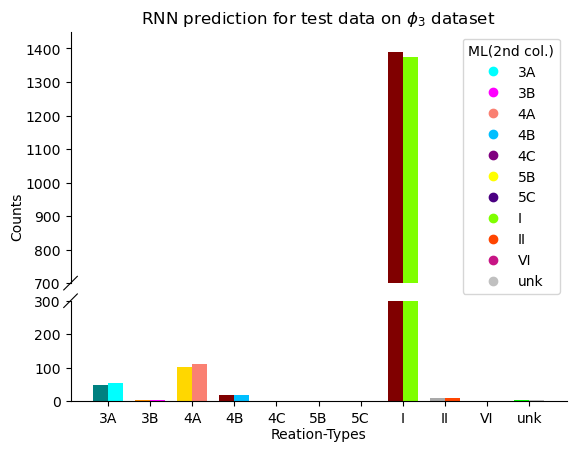

In [8]:
y_test_plot = list(counter_data_sorted.values())
y_data_plot = list(counter_pred_sorted.values())

# Create an array of x-axis values
x_ticks_label_new = list(counter_data_sorted.keys())
x_test_new = np.arange(len(x_ticks_label_new))

# Set up the figure
width = 0.35  # the width of the bars
ind = np.arange(len(x_ticks_label_new))
baxes = brokenaxes(ylims=((0, 300), (700, 1450)), hspace=.1)

# Define a list of colors for each category
colors_data = ['teal', 'darkorange', 'gold', 'maroon', 'dodgerblue', 'mediumslateblue', 'hotpink', 'maroon', 'darkgray', 'black', 'lime']

# Plot the original data bars
for i in range(len(x_ticks_label_new)):
    baxes.bar(ind[i] - width/2, y_test_plot[i], width, color=colors_data[i], label=x_ticks_label_new[i])

# Plot the predicted data bars with contrasting colors to colors_data
#colors_ml = ['cyan', 'magenta', 'lime', 'deepskyblue', 'purple', 'yellow', 'indigo', 'chartreuse', 'orangered', 'mediumvioletred', 'silver']
colors_ml = ['cyan', 'magenta', 'salmon', 'deepskyblue', 'purple', 'yellow', 'indigo', 'chartreuse', 'orangered', 'mediumvioletred', 'silver']

for i in range(len(x_ticks_label_new)):
    baxes.bar(ind[i] + width/2, y_data_plot[i], width, color=colors_ml[i])

# Add labels and title
# Add some text for labels, title and custom x-axis tick labels, etc.
baxes.set_ylabel('Counts')
baxes.set_xlabel('Reation-Types')
baxes.set_title('RNN prediction for test data on $\phi_3$ dataset')
baxes.set_xticks(ind)
#baxes.set_xticklabels(np.arange(len(x_ticks_label_new)))
baxes.axs[1].set_xticks(x_test_new, x_ticks_label_new)
baxes.legend()

# Create a custom legend for the ML prediction colors
ml_legend_elements = [plt.Line2D([0], [0], color=colors_ml[i], marker='o', linestyle='', label=x_ticks_label_new[i]) for i in range(len(x_ticks_label_new))]
baxes.legend(handles=ml_legend_elements, title='ML(2nd col.)', loc='upper right')


#plt.savefig('RNN_results_phi1')
# Show the plot
plt.show()